**Setup**

In [1]:
import os, time, sys
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import preprocessing
import scipy.io
import math

In [2]:
%matplotlib inline

In [3]:
# Constants
NUM_ATOMS = 23
NUM_SAMPLES = 7165
RANDOM_SEED = 42

In [4]:
# Reproducibility
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [5]:
if not os.path.exists('qm7.mat'): os.system('wget http://www.quantum-machine.org/data/qm7.mat')
qm7 = scipy.io.loadmat('qm7.mat')

**Examine some graph statistics of first graph**

In [6]:
G_first = nx.from_numpy_matrix(qm7['X'][0])

print(f'Number of nodes: {G_first.number_of_nodes()}')
print(f'Number of edges: {G_first.number_of_edges()}')
print(f'Average node degree: {G_first.number_of_edges() / G_first.number_of_nodes():.2f}')
print(f'Isolated nodes: {list(nx.isolates(G_first))}')
print(f'Self-loops: {list(nx.selfloop_edges(G_first))}')

Number of nodes: 23
Number of edges: 15
Average node degree: 0.65
Isolated nodes: [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
Self-loops: [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]


**Pre-processing data**

In [7]:
# Sorting Coulomb matrix by row norm
list_sorted_coulomb_mat = []

for coulomb_mat in qm7['X']:
    sorted_idx = np.argsort(np.linalg.norm(coulomb_mat, axis=1))  
    sorted_coulomb_mat = coulomb_mat[sorted_idx, :]  # Sort rows
    sorted_coulomb_mat.sort(axis=1)  # Sort each element in a row
    list_sorted_coulomb_mat.append(sorted_coulomb_mat)

sorted_coulomb_mat = np.array(list_sorted_coulomb_mat)

In [8]:
# X is set of Coulomb matrices
X = sorted_coulomb_mat
X_reshaped = sorted_coulomb_mat.reshape(NUM_SAMPLES, NUM_ATOMS*NUM_ATOMS)

# y is their ground-truth atomization energies
y = np.transpose(qm7['T']).reshape((7165,))
y_scaling_factor = np.max(np.absolute(y))
# y_scaling_factor = np.linalg.norm(y)
y_scaled = y/y_scaling_factor

**Visualizing some Coulomb matrix**

Plotting molecular graphs: [ 860 5390 5226 5191 3772]


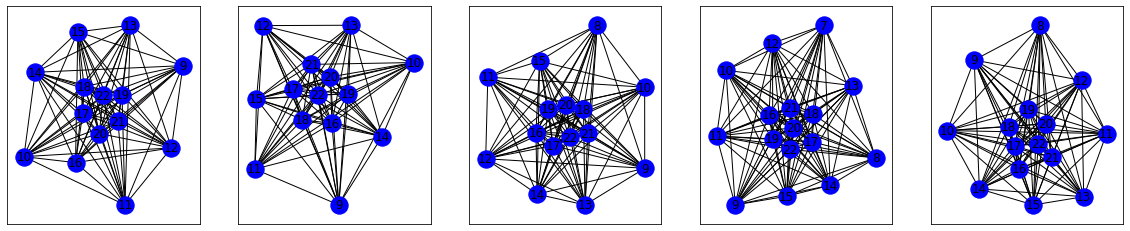

In [9]:
# Plotting five randomly chosen Coulomb matrices (without isolated vertices)
fig, ax = plt.subplots(1, 5, figsize=(20, 4))

graph_idx = np.random.randint(0, NUM_SAMPLES, size=5)
print("Plotting molecular graphs: {}".format(graph_idx))

for i, idx in enumerate(graph_idx):
    G = nx.from_numpy_matrix(list_sorted_coulomb_mat[idx])
    G.remove_nodes_from(list(nx.isolates(G)))
    G.remove_edges_from(nx.selfloop_edges(G))
    nx.draw_networkx(G, nx.spring_layout(G), ax=ax[i], node_color='b')

**Feature engineering: graph topology information**

In [10]:
# Eigenvalues, eigenvectors
eigval_X = []
eigvec_X = []
for i in range(X.shape[0]):
    eigval, eigvec = np.linalg.eig(X[i, :, :])
    eigval_X.append(eigval)
    eigvec_X.append(eigvec.flatten())
# Note: Spectral Theorem guarantees real-valued eigenvalues and eigenvectors (can safely cast complex values to np.float64)
X_reshaped_with_eigfeature = np.concatenate((np.array(eigvec_X), np.array(eigval_X), X_reshaped), axis=1).astype(np.float64)
print("Dimensions of X_reshaped_with_eigfeature: {}".format(X_reshaped_with_eigfeature.shape))

Dimensions of X_reshaped_with_eigfeature: (7165, 1081)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


In [11]:
# Centralities (eigen-centralities)
eigcentralities = []

for g_mat in list_sorted_coulomb_mat:
    G = nx.from_numpy_matrix(g_mat)
    G.remove_edges_from(nx.selfloop_edges(G))
    dict_eigcentrality = nx.eigenvector_centrality_numpy(G)  # Dictionary of eigencentrality of each node
    list_eigcentrality = [dict_eigcentrality[key] for key in range(len(dict_eigcentrality))]
    eigcentralities.append(list_eigcentrality)
X_reshaped_with_eigfeature_with_eigcentrality = np.concatenate((X_reshaped_with_eigfeature, np.array(eigcentralities)), axis=1).astype(np.float64)
print("Dimensions of X_reshaped_with_eigfeature_with_eigcentrality: {}".format(X_reshaped_with_eigfeature_with_eigcentrality.shape))

Dimensions of X_reshaped_with_eigfeature_with_eigcentrality: (7165, 1104)


**XGBoost**

In [12]:
import xgboost as xgb

start_time = time.time()

NUM_FOLDS = 5
EARLY_STOPPING = 20
NUM_EPOCHS = 50

xg_data = xgb.DMatrix(X_reshaped, label=y_scaled)

# Setting some parameters (avoid touching hyperparameters)
params = {"objective": "reg:squarederror",
          "seed": RANDOM_SEED,
          "eval_metric": "mae",
          "booster": "gbtree",
          "n_threads": -1}

# Cross-validating
xgb_cv = xgb.cv(params,
            xg_data, 
            num_boost_round=NUM_EPOCHS, 
            nfold=NUM_FOLDS, 
            early_stopping_rounds=EARLY_STOPPING, 
            verbose_eval = 0, 
            seed=RANDOM_SEED,
            as_pandas=False,
            shuffle=True)

print("Cross-validation done in %s seconds" % (time.time() - start_time))

Cross-validation done in 40.649367332458496 seconds


Test loss: 8.7837824


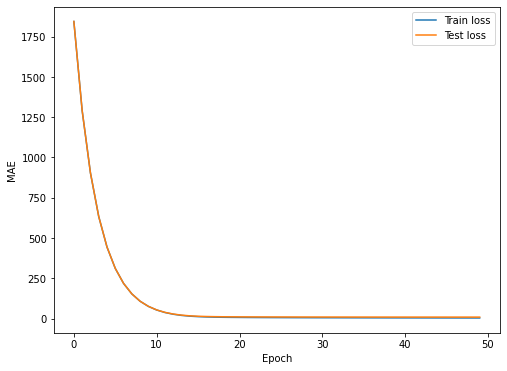

In [31]:
# Performance
final_test_mae_mean = np.min(xgb_cv['test-mae-mean'])
print("Cross-validation loss: {}".format(final_test_mae_mean*y_scaling_factor))

# Plotting training process
plt.figure(figsize=(8,6))
plt.plot([x*y_scaling_factor for x in xgb_cv['train-mae-mean']], label='Train loss')
plt.plot([x*y_scaling_factor for x in xgb_cv['test-mae-mean']], label='Test loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.show()

**Kernel Ridge Regression**

In [37]:
from sklearn.kernel_ridge import KernelRidge

start_time = time.time()

# Define model
krr_model = KernelRidge(alpha = 1e-4, kernel = "rbf", gamma=1e-4)

# Define model evaluation method
krr_cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

krr_cross_val_score = np.absolute(cross_val_score(krr_model, X_reshaped, y_scaled, scoring='neg_mean_absolute_error', cv=krr_cv, n_jobs=-1))
print("Cross-validation done in %s seconds" % (time.time() - start_time))
print("Min of cross-validation score: {}".format(np.min(krr_cross_val_score)*y_scaling_factor))
print("(Variance: {})".format(np.var(krr_cross_val_score)*(y_scaling_factor**2)))

Cross-validation done in 11.83364486694336 seconds
Min of cross-validation score: 4.709694590419531
(Variance: 0.0200603601087027)


**Support Vector Regression**

In [36]:
from sklearn.svm import SVR

start_time = time.time()

# Define model
svr_model = SVR(kernel='rbf', gamma=1e-4, epsilon=1e-6)

# Define model evaluation method
svr_cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

svr_cross_val_score = np.absolute(cross_val_score(svr_model, X_reshaped, y_scaled, scoring='neg_mean_absolute_error', cv=svr_cv, n_jobs=-1))
print("Cross-validation done in %s seconds" % (time.time() - start_time))
print("Min of cross-validation score: {}".format(np.min(svr_cross_val_score)*y_scaling_factor))
print("(Variance: {})".format(np.var(svr_cross_val_score)*(y_scaling_factor**2)))

Cross-validation done in 63.59053301811218 seconds
Min of cross-validation score: 6.514286595399967
(Variance: 0.02673433106058408)


**Linear Regression**

In [11]:
from sklearn import linear_model

start_time = time.time()

# Define model
linreg_model = linear_model.Ridge(alpha=.5)

# Define model evaluation method
linreg_cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

linreg_cross_val_score = np.absolute(cross_val_score(linreg_model, X_reshaped, y_scaled, scoring='neg_mean_absolute_error', cv=linreg_cv, n_jobs=-1))
print("Cross-validation done in %s seconds" % (time.time() - start_time))
print("Min of cross-validation score: {}".format(np.min(linreg_cross_val_score)*y_scaling_factor))
print("(Variance: {})".format(np.var(linreg_cross_val_score)*(y_scaling_factor**2)))

Cross-validation done in 0.62204909324646 seconds
Min of cross-validation score: 17.912396892905235
(Variance: 0.028519243089729987)


**Vanilla neural network**

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Rescaling, BatchNormalization
from keras import optimizers

NUM_FOLDS = 5
NUM_EPOCHS = 200
NUM_FEATURES = 529
    
# Define the neural network
vanilla_model = Sequential()
vanilla_model.add(Dense(128, kernel_initializer='he_normal', input_dim=NUM_FEATURES, activation='relu'))
vanilla_model.add(BatchNormalization())
vanilla_model.add(Dense(64, kernel_initializer='he_normal', activation='relu'))
vanilla_model.add(BatchNormalization())
vanilla_model.add(Dense(32, kernel_initializer='he_normal', activation='relu'))
vanilla_model.add(BatchNormalization())
vanilla_model.add(Dense(16, kernel_initializer='he_normal', activation='relu'))
vanilla_model.add(BatchNormalization())
vanilla_model.add(Dense(8, kernel_initializer='he_normal', activation='relu'))
vanilla_model.add(BatchNormalization())
vanilla_model.add(Dense(1, kernel_initializer='he_normal', activation='linear'))

# Compile
vanilla_model.compile(loss='mean_absolute_error', optimizer='adam')

print(vanilla_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               67840     
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_2 (Batc  (None, 32)               1

In [13]:
start_time = time.time()

# Fit data to model
vanilla_history = vanilla_model.fit(X_reshaped, y_scaled, epochs=NUM_EPOCHS, validation_split=1/NUM_FOLDS)

print('Execution time: %s seconds' % (time.time() - start_time))

Epoch 1/200
180/180 [==============================] - 2s 4ms/step - loss: 0.4568 - val_loss: 0.3108
Epoch 2/200
180/180 [==============================] - 1s 3ms/step - loss: 0.0788 - val_loss: 0.0843
Epoch 3/200
180/180 [==============================] - 1s 3ms/step - loss: 0.0652 - val_loss: 0.0882
Epoch 4/200
180/180 [==============================] - 1s 3ms/step - loss: 0.0470 - val_loss: 0.0770
Epoch 5/200
180/180 [==============================] - 1s 3ms/step - loss: 0.0392 - val_loss: 0.0491
Epoch 6/200
180/180 [==============================] - 1s 3ms/step - loss: 0.0350 - val_loss: 0.0521
Epoch 7/200
180/180 [==============================] - 1s 3ms/step - loss: 0.0320 - val_loss: 0.0449
Epoch 8/200
180/180 [==============================] - 1s 3ms/step - loss: 0.0320 - val_loss: 0.0590
Epoch 9/200
180/180 [==============================] - 1s 3ms/step - loss: 0.0320 - val_loss: 0.1227
Epoch 10/200
180/180 [==============================] - 1s 3ms/step - loss: 0.0295 - val_lo

Cross-validation loss:  19.109518706798553


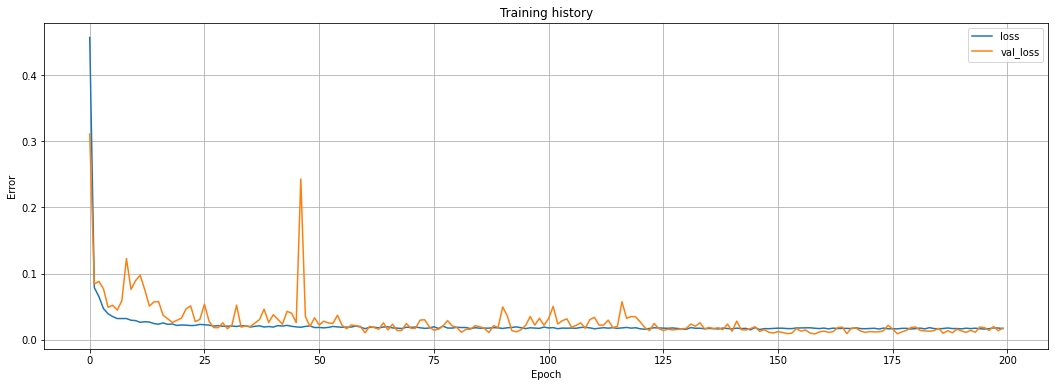

In [16]:
# Plot training history
plt.figure(figsize=(18, 6))
plt.plot(vanilla_history.history['loss'], label='loss')
plt.plot(vanilla_history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Training history')
plt.legend()
plt.grid(True)

# Performance
print('Cross-validation loss: ', y_scaling_factor*np.min(vanilla_history.history['val_loss']))

**2D Convolutional Neural Network with binarization**

In [19]:
# Binarization of data with width=11, theta=1
THETA = 1
WIDTH = 11

X = sorted_coulomb_mat

list_binarized_X = []
for i in [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]:
    list_binarized_X.append(np.tanh((X+(THETA*i))/THETA))

binarized_X = np.stack(list_binarized_X, axis=3)
print("Shape of binarized_X: {}".format(binarized_X.shape))

Shape of binarized_X: (7165, 23, 23, 11)


In [20]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Rescaling, BatchNormalization, Flatten
from keras import optimizers
from keras.callbacks import EarlyStopping

NUM_FOLDS = 5
NUM_EPOCHS = 300
    
# Define the neural network
binarized_model = Sequential()
binarized_model.add(Conv2D(64, (10, 10), activation='relu', kernel_initializer='he_normal', input_shape=(NUM_ATOMS, NUM_ATOMS, WIDTH)))
binarized_model.add(BatchNormalization())
binarized_model.add(Conv2D(64, (4, 4), activation='relu', kernel_initializer='he_normal'))
binarized_model.add(BatchNormalization())
binarized_model.add(Conv2D(32, (10, 10), activation='relu', kernel_initializer='he_normal'))
binarized_model.add(BatchNormalization())
binarized_model.add(Conv2D(32, (2, 2), activation='relu', kernel_initializer='he_normal'))
binarized_model.add(BatchNormalization())
binarized_model.add(Conv2D(8, (1, 1), activation='relu', kernel_initializer='he_normal'))
binarized_model.add(Flatten())
binarized_model.add(Dense(1, activation='linear'))

# # Early stopping
# estop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

# Compile
binarized_model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

print(binarized_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        70464     
                                                                 
 batch_normalization_5 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        65600     
                                                                 
 batch_normalization_6 (Batc  (None, 11, 11, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 32)          204832    
                                                                 
 batch_normalization_7 (Batc  (None, 2, 2, 32)        

In [21]:
# Keras Convolutional Neural Network with Cross-validation
from sklearn.model_selection import KFold

start_time = time.time()

kfold = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=RANDOM_SEED)

# K-fold Cross Validation fitting and evaluating
loss_per_fold = []
fold_no = 1
for train, test in kfold.split(binarized_X, y_scaled):
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    binarized_history = binarized_model.fit(binarized_X[train], y_scaled[train], epochs=NUM_EPOCHS)

    # Generate generalization metrics
    score = binarized_model.evaluate(binarized_X[test], y_scaled[test], verbose=0)
    print(f'Score for fold {fold_no}: {binarized_model.metrics_names} of {score}')
    loss_per_fold.append(score)

    # Increase fold number
    fold_no = fold_no + 1

print('Execution time: %s seconds' % (time.time() - start_time))

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/300
180/180 [==============================] - 10s 6ms/step - loss: 0.2038
Epoch 2/300
180/180 [==============================] - 1s 5ms/step - loss: 0.0846
Epoch 3/300
180/180 [==============================] - 1s 5ms/step - loss: 0.0654
Epoch 4/300
180/180 [==============================] - 1s 5ms/step - loss: 0.0482
Epoch 5/300
180/180 [==============================] - 1s 5ms/step - loss: 0.0494
Epoch 6/300
180/180 [==============================] - 1s 5ms/step - loss: 0.0764
Epoch 7/300
180/180 [==============================] - 1s 5ms/step - loss: 0.0434
Epoch 8/300
180/180 [==============================] - 1s 5ms/step - loss: 0.0410
Epoch 9/300
180/180 [==============================] - 1s 5ms/step - loss: 0.0389
Epoch 10/300
180/180 [==============================] - 1s 5ms/step - loss: 0.0364
Epoch 11/300
180/180 [==============================] - 1s 5ms/step - loss: 0.033

CV loss per fold: [40.7810318171978, 13.600952692329884, 17.93038010597229, 12.208743944764137, 9.249840900301933]
Min of cross-validation loss: 9.249840900301933


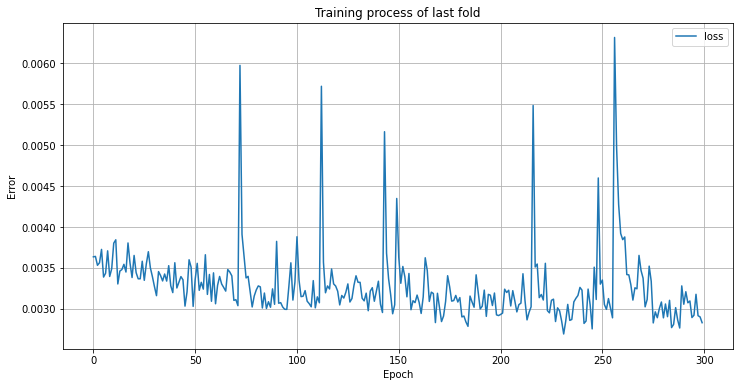

In [34]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(binarized_history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Training process of last fold')
plt.legend()
plt.grid(True)

# Performance
# for i in range(len(loss_per_fold)):
#     print('Test loss for fold {}: {}'.format(i+1, y_scaling_factor*loss_per_fold[i]))
print("CV loss per fold: {}".format([x*y_scaling_factor for x in loss_per_fold]))
print("Min of cross-validation loss: {}".format(np.min(np.array(loss_per_fold))*y_scaling_factor))